# Write Database

In [1]:
import os
import cv2
import lmdb
from random import Random
from matplotlib import pyplot as plt
from psutil import virtual_memory
import click
import time
from glob import glob
import numpy as np
import math

In [2]:
def writeFileList(dirNameArr):
    """
    Returns the python list object of the files under a directory name for processing later
    """
    '''
    if isinstance(dirNameArr, basestring): # someone only inputed a single string, so make it a list so that this code works

        dirNameArr = [dirNameArr]
    '''
    dirNameArr = [dirNameArr]
    files_list = [] # list of all files with full path
    for dirName in dirNameArr: 
    # loop through all files in the list of directory names inputted. This is useful for multiple datasets	
        with click.progressbar(os.walk(dirName), label="Parsing files in "+dirName) as bar:
            for dirname, dirnames, filenames in bar:
                for filename in filenames:
                    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg') or filename.endswith('.bmp') or filename.endswith('.tiff'):	
                        fileName = glob(os.path.join(dirname, filename)) 
                        files_list += fileName
 
    return files_list,len(files_list)

# Model and Train

In [3]:
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from PIL import Image

In [4]:
from Model import Model

In [5]:
#dirName = 'D:\\workspace\\proj7643\\CampusLoopDataset\\live'
dirName = 'D:\\workspace\\data\\train_256_places365standard'
t0 = time.time()
files_list,total_number = writeFileList(dirName)
t1 = time.time()
print ('\n\nLoading Paths: ', (t1-t0) , ' seconds')



Loading Paths:  165.1341781616211  seconds


In [6]:
device  = torch.device("cuda:0")

model = Model().to(device)
#PATH = 'model\\model.pth'
#model.load_state_dict(torch.load(PATH))
#criterion = nn.MSELoss(reduction = 'sum')

In [7]:
criterion = nn.L1Loss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=1e-5,weight_decay=0.995)

In [8]:
class TrainingSet(Dataset):
    def __init__(self,paths,total_number,h=120,w=160):
        self.h = h
        self.w = w
        self.length = total_number
        self.hog = cv2.HOGDescriptor((16, 32), (16,16), (16,16), (8,8), 2,1)
        self.imgs = paths
        self.r = Random(0)
        
    def __len__(self):
        return self.length
        
    def loader(self,path):
        img = cv2.imread(path,0)
        img = cv2.resize(img, (self.w, self.h), interpolation = cv2.INTER_CUBIC)
        #img = cv2.resize(img,(self.h,self.w))
        #img_tensor = torch.from_numpy(img).to(device)
        return img
    
    def randPerspectiveWarp(self,im):
        w = self.w
        h = self.h
        r = self.r
        minsx = [ 0, 3*w/4 ]
        maxsx = [ w/4, w ]
        minsy= [ 0, 3*h/4 ]
        maxsy = [ h/4, h ]


        pts_orig = np.zeros((4, 2), dtype=np.float32)
        pts_warp = np.zeros((4, 2), dtype=np.float32) 
        pts_orig[0, 0] = 0
        pts_orig[0, 1] = 0
    
        pts_orig[1, 0] = 0
        pts_orig[1, 1] = h

        pts_orig[2, 0] = w
        pts_orig[2, 1] = 0

        pts_orig[3, 0] = w
        pts_orig[3, 1] = h
        pts_warp[0, 0] = r.uniform(minsx[0], maxsx[0])
        pts_warp[0, 1] = r.uniform(minsy[0], maxsy[0])
    
        pts_warp[1, 0] = r.uniform(minsx[0], maxsx[0])
        pts_warp[1, 1] = r.uniform(minsy[1], maxsy[1])

        pts_warp[2, 0] = r.uniform(minsx[1], maxsx[1])
        pts_warp[2, 1] = r.uniform(minsy[0], maxsy[0])

        pts_warp[3, 0] = r.uniform(minsx[1], maxsx[1])
        pts_warp[3, 1] = r.uniform(minsy[1], maxsy[1])

    # compute the 3x3 transform matrix based on the two planes of interest
        T = cv2.getPerspectiveTransform(pts_warp, pts_orig)

    # apply the perspective transormation to the image, causing an automated change in viewpoint for the net's dual input
        im_warp = cv2.warpPerspective(im, T, (w, h))
        return im_warp
    
    def __getitem__(self,index):
        path = self.imgs[index]
        #print(path)
        ori_img = self.loader(path)
        img_warp = self.randPerspectiveWarp(ori_img)
        #ori_img = cv2.cvtColor(ori_img,cv2.IMREAD_GRAYSCALE)
        #img_warp = cv2.cvtColor(img_warp,cv2.IMREAD_GRAYSCALE)
        #plt.imshow(ori_img)
        #plt.axis('off')
        #plt.show()
        #plt.imshow(img_warp)
        #plt.axis('off')
        #plt.show()
        self.r.seed(index) # adds extra randomness, but is still reproduceable with the same dataset
        switchFlag = self.r.randint(0,1)
        if switchFlag:
            img = img_warp
            des = self.hog.compute(cv2.resize(ori_img, (160,120)))
            #print(des)
        else:
            img = ori_img
            des = self.hog.compute(cv2.resize(img_warp, (160,120)))
        #img = torch.from_numpy(img).to(device)
        #des = torch.from_numpy(des).to(device)
        #print(img.dtype)
        #print(des.dtype)
        img = img.reshape(1,self.h,self.w)
        des = des.reshape(3648,)
        return img,des

In [15]:
batch_size = 512
PATH = 'model\\model.pth'
trainingset = TrainingSet(files_list,total_number)
trainloader = DataLoader(trainingset,batch_size,shuffle=True)
max_epochs = 100
iters = math.ceil(total_number/batch_size)
for epoch in range(max_epochs):
    avgloss = 0.0 # This loss is the average loss of an epoch
    t0 = time.time()
    for i,data in enumerate(trainloader):
        imgs,desps = data
        #print(imgs.shape)
        #print(desps.shape)
        #temp = imgs[0,:,:,:].reshape(120,160,1)
        #print(temp)
        #img = cv2.cvtColor(np.uint8(temp),cv2.IMREAD_GRAYSCALE)
        #plt.imshow(img)
        #plt.axis('off')
        #plt.show()
        #imgs,desps = data
        #print(imgs.dtype)
        imgs,desps = imgs.to(device=device,dtype=torch.float), desps.to(device=device,dtype=torch.float)
        #cv2.imshow(imgs)
        #print(torch.mean(desps))
        optimizer.zero_grad()
        outputs = model(imgs)
        #print(outputs[22,:])
        #print(desps[0,:])
        loss = criterion(outputs,desps)
        loss.backward()
        optimizer.step()
        #print('loss:%.3f'%loss.item())
        avgloss += loss.item()
        print('[Epoch %d,iteration %d] loss: %5f'%(epoch + 1,i+1,loss.item()))
        if i%iters==iters-1:#According to the size of the dataset and batchsize
            print('[Epoch %d] loss: %.3f time used: %.3f' %
                      (epoch + 1, avgloss / 70,time.time()-t0))
            avgloss = 0.0
    if epoch%10 == 9:
        CP_PATH = 'model\\model_'+str(epoch)+'.pth'
        torch.save(model.state_dict(),CP_PATH)
    elif epoch%2 == 1:
        torch.save(model.state_dict(), PATH)
        print('small step checkpoint saved')
        

[Epoch 1,iteration 1] loss: 258082.750000
[Epoch 1,iteration 2] loss: 253668.156250
[Epoch 1,iteration 3] loss: 249042.187500
[Epoch 1,iteration 4] loss: 244373.093750
[Epoch 1,iteration 5] loss: 239968.140625
[Epoch 1,iteration 6] loss: 236326.406250
[Epoch 1,iteration 7] loss: 230466.218750
[Epoch 1,iteration 8] loss: 226264.609375
[Epoch 1,iteration 9] loss: 221387.937500
[Epoch 1,iteration 10] loss: 217301.843750
[Epoch 1,iteration 11] loss: 212598.593750
[Epoch 1,iteration 12] loss: 209069.796875
[Epoch 1,iteration 13] loss: 204679.750000
[Epoch 1,iteration 14] loss: 199508.781250
[Epoch 1,iteration 15] loss: 195137.593750
[Epoch 1,iteration 16] loss: 191863.968750
[Epoch 1,iteration 17] loss: 186461.078125
[Epoch 1,iteration 18] loss: 181685.937500
[Epoch 1,iteration 19] loss: 177893.375000
[Epoch 1,iteration 20] loss: 174238.734375
[Epoch 1,iteration 21] loss: 170370.093750
[Epoch 1,iteration 22] loss: 166682.000000
[Epoch 1,iteration 23] loss: 162881.015625
[Epoch 1,iteration 2

KeyboardInterrupt: 

# Test and evaluation

In [16]:
from sklearn.metrics import precision_recall_curve, auc
from matplotlib import pyplot as plt, rcParams
import re
from os import path, getcwd, listdir, makedirs
import sys
from matplotlib.font_manager import FontProperties

In [17]:
def smooth_pr(prec, rec):
    """
    Smooths precision recall curve according to TREC standards. Evaluates max precision at each 0.1 recall. Makes the curves look nice and not noisy
    """

    n = len(prec)
    m = 11
    p_smooth = np.zeros((m), dtype=np.float)
    r_smooth = np.linspace(0.0, 1.0, m) 
    for i in range(m):
        j = np.argmin( np.absolute(r_smooth[i] - rec) ) + 1
        p_smooth[i] = np.max( prec[:j] )

    return p_smooth, r_smooth

In [18]:
def check_match(im_lab_k, db_lab, num_include):
    """
    Check if im_lab_k and db_lab are a match, i.e. the two images are less than or equal to
    num_include frames apart. The correct num_include to use depends on the speed of the camera, both for frame rate as well as physical moving speed.
    """	
    if num_include == 1:
        if db_lab ==im_lab_k:
            return True
    else:
        # This assumes that db_lab is a string of numerical characters, which it should be	
        #print int(db_lab)-num_include/2, "<=", int(im_lab_k), "<=", int(db_lab)+num_include/2, "?"
        if (int(db_lab)-num_include/2) <= int(im_lab_k) and int(im_lab_k) <= (int(db_lab)+num_include/2):
            return True

    return False

In [19]:
def computeForwardPass(model, im): 
    ###########################################
    #I tried to pass model as a parameter but it failed:
    #                           'module' object is not callable
     #######################################
    """
    Compute the forward pass for the model
    """
    t0 = time.time()
    img_yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    im = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    if im.shape[2] > 1:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (160, 120), interpolation = cv2.INTER_CUBIC).reshape(1,1,120,160)
    im = torch.from_numpy(im).to(device=device,dtype=torch.float)
    #im = torch.from_numpy(im).float()
    with torch.no_grad():
        
        output = model(im)
        output /= np.linalg.norm(output.cpu())
        descriptor = output
        t_calc = (time.time() - t0)

    return descriptor, t_calc


In [20]:
def get_prec_recall(model,data_path="test_data/CampusLoopDataset", num_include=7, title='Precision-Recall Curve'):
    """
    Input: 
    data_path="test_data/CampusLoopDataset",: Path to data with corresponding images (with corresponding file names) in a <data-dir>/live and <data-dir>/memory
    """
    '''
    model = Model().to(device)
    model.load_state_dict(torch.load(model_path))
    '''
    database = [] # stored pic descriptors
    database_labels = [] # the image labels	

    mem_path = data_path + "\\memory"
    live_path = data_path + "\\live"

    print ("memory path: ", mem_path)
    print ("live path: ", live_path)

    mem_files = [path.join(mem_path, f) for f in listdir(mem_path)]
    live_files = [path.join(live_path, f) for f in listdir(live_path)]

    # same HOG params used to train calc
    hog = cv2.HOGDescriptor((16, 32), (16,16), (16,16), (8,8), 2,1)
    db_hog = []

    t_calc = []

    for fl in mem_files:
        im = cv2.imread(fl)
        print ("loading image ", fl, " to database")
        descriptor, t_r = computeForwardPass(model, im)
        '''
        ################################
        img_yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        im = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

        if im.shape[2] > 1:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im = cv2.resize(im, (160, 120), interpolation = cv2.INTER_CUBIC)
    
    
        with torch.no_grad():
            t0 = time.time()
            output = model(im)
            output /= np.linalg.norm(output)
            descriptor = output
            tr = (time.time() - t0)
        ################################    
        '''
        t_calc.append(t_r)
        database.append(descriptor)
        database_labels.append(re.match('.*?([0-9]+)$', path.splitext(path.basename(fl))[0]).group(1))
        d_hog = hog.compute(cv2.resize(cv2.cvtColor(im,cv2.COLOR_BGR2GRAY), (160, 120), interpolation = cv2.INTER_CUBIC))
        db_hog.append(d_hog/np.linalg.norm(d_hog))
        #print(d_hog)
        #db_hog.append(d_hog)

    #print database

    correct = np.zeros((len(live_files),1),dtype=np.uint8) # the array of true labels of loop closure for precision-recall curve for each net
    scores = np.zeros((len(live_files),1))  # Our "probability function" that  simply uses 1-l2_norm

    correct_hog = []
    scores_hog = []
    
    k=0
    t_q = []
    for fl in live_files:
        im_label_k = re.match('.*?([0-9]+)$', path.splitext(path.basename(fl))[0]).group(1)
        im = cv2.imread(fl)

        descriptor, t_r = computeForwardPass(model, im)
        '''
        ################################
        img_yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        im = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

        if im.shape[2] > 1:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im = cv2.resize(im, (160, 120), interpolation = cv2.INTER_CUBIC)
    
    
        with torch.no_grad():
            t0 = time.time()
            output = model(im)
            output /= np.linalg.norm(output)
            descriptor = output
            tr = (time.time() - t0)
        ################################
        '''
        t_calc.append(t_r)

        d_hog = hog.compute(cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), (160, 120), interpolation = cv2.INTER_CUBIC))
        d_hog /= np.linalg.norm(d_hog)

        max_sim = -1.0 
        max_sim_hog = -1.0

        i_max_sim = -1 * np.ones(1, dtype=np.int32)
        i_max_sim_hog = -1
        t_q_single = 0.0
        for i in range(len(database)):
            #print(descriptor.dtype)
            #print(database[i].dtype)
            #print(descriptor.shape)
            #print(database[i].shape)
            #print(descriptor.squeeze())
            #print(database[i].squeeze())
            #curr_sim = torch.dot(descriptor.squeeze(), database[i].squeeze())# Normalizd vectors means that this give cosine similarity
            t0 = time.time()
            curr_sim = np.dot(descriptor.cpu(), database[i].cpu().T)
            print(curr_sim)
            if curr_sim > max_sim: 
                max_sim = curr_sim
                i_max_sim = i
            t1 = time.time()

            curr_sim_hog = np.squeeze(np.dot(d_hog.T,  db_hog[i])) 
            if curr_sim_hog > max_sim_hog: 
                max_sim_hog = curr_sim_hog
                i_max_sim_hog = i
            t_q_single+=(t1-t0)
            #print(t1-t0)
        
        #scores[k] = max_sim.cpu()
        t0 = time.time()
        scores[k] = max_sim
        db_lab = database_labels[i_max_sim]  
        if check_match(im_label_k, db_lab, num_include):
            correct[k] = 1
            # else already 0
        #print(len(database_labels))
        #print(correct.shape)
        #print(i_max_sim)
        #print(k)
        t1 = time.time()
        t_q_single+=(t1-t0)
        t_q.append(t_q_single)
        print(t_q_single)
        print ("Proposed match calc:", im_label_k, ", ", database_labels[i_max_sim], ", score = ", max_sim, ", Correct =", correct[k])

        scores_hog.append( max_sim_hog )
        db_lab_hog = database_labels[i_max_sim_hog]  
        if check_match(im_label_k, db_lab_hog, num_include):
            correct_hog.append(1)
        else:
            correct_hog.append(0)
        print ("Proposed match HOG:", im_label_k, ", ", database_labels[i_max_sim_hog], ", score = ", max_sim_hog,", Correct =", correct_hog[-1])

        print ("\n")
        k += 1

    precisions = []
    recalls = []
    threshold = -1.0

    precision, recall, threshold = precision_recall_curve(correct, scores)
    precisions.append(precision)
    recalls.append(recall)
    # Only get threshold if there's one net. Otherwise we're just coparing them and don't care about a threshold yet
    perf_prec = abs(precision[:-1] - 1.0) <= 1e-6
    #print(precision)
    #print(perf_prec)
    if np.any(perf_prec):
        # We want the highest recall rate with perfect precision as our a-priori threshold
        threshold = np.min(threshold[perf_prec]) # get the largest threshold so that presicion is 1
        #print(threshold.shape)
        print ("\nThreshold for max recall with 1.0 precision = %f" % (threshold) )

    precision_hog, recall_hog, thresholds_hog = precision_recall_curve(correct_hog, scores_hog)
    t_calc = np.asarray(t_calc)
    t_q = np.asarray(t_q)
    #print(t_calc.shape)
    print ("Mean calc compute time = ", np.sum(t_calc)/ np.size(t_calc))
    print ("Mean query compute time = ", np.sum(t_q)/ np.size(t_q))
    

    return precisions, recalls,precision_hog, recall_hog

In [21]:
def plot(model, data_path="test_data/CampusLoopDataset", num_include=7, title='Precision-Recall Curve'):
    """
    Plot the precision recall curve to compare CALC to other methods, or cross validate different iterations of a CALC model.
    """
        
    t0 = time.time()

    precisions, recalls, precision_hog, recall_hog = get_prec_recall(model,data_path, num_include, title)

    rcParams['font.sans-serif'] = 'DejaVu Sans'
    rcParams['font.weight'] = 'bold'
    rcParams['axes.titleweight'] = 'bold'	
    rcParams['axes.labelweight'] = 'bold'	
    rcParams['axes.labelsize'] = 'large'	
    rcParams['figure.figsize'] = [8.0, 4.0]	
    rcParams['figure.subplot.bottom'] = 0.2	
    plots = path.join(getcwd(), "plots")
    rcParams['savefig.directory'] = plots
    if not path.isdir(plots):
        makedirs(plots)

    lines = ['-','--','-.',':','.',',','o','v','^','<','>','1','2','3','4','s','p','*','h','H','+','x','D','d','|','_']

    ax = plt.gca()
    best_auc = -1 
    lab_best_auc = ""
    handles = []
    p_smooth, r_smooth = smooth_pr(precisions, recalls)
    curr_auc = auc(r_smooth, p_smooth)
    label = ' (AUC=%0.2f)' % (curr_auc)

    calc_plt, = ax.plot(r_smooth, p_smooth, '-', label=label, linewidth=2)

    handles.append(calc_plt)
    if curr_auc > best_auc:
        lab_best_auc = label
        best_auc = curr_auc	
    # Only tell the user the most accurate net if they loaded more than one!
    if len(precisions) > 1:
        print("Model with highest AUC:", lab_best_auc)


    print ("\n\n\n\n")
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.title(title)

    p_smooth, r_smooth = smooth_pr(precision_hog, recall_hog)
    lab = 'HOG (AUC=%0.2f)' % (auc(r_smooth, p_smooth))
    hog_plt, = ax.plot(r_smooth, p_smooth, '-.', label=lab, linewidth=2)
    handles.append(hog_plt)
    fontP = FontProperties()
    fontP.set_size('small')
    leg = ax.legend(handles=handles, fancybox=True, ncol = (1 + int(len(precisions)/30)), loc='best', prop=fontP)
    leg.get_frame().set_alpha(0.5) # transluscent legend 
    leg.set_draggable(True)
    for line in leg.get_lines():
        line.set_linewidth(3)

    print ("Elapsed time = ", time.time()-t0, " sec")
    plt.show()

memory path:  D:\workspace\proj7643\CampusLoopDataset\memory
live path:  D:\workspace\proj7643\CampusLoopDataset\live
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image001.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image002.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image003.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image004.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image005.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image006.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image007.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image008.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image009.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image010.jpg  to database
lo

loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image099.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image100.jpg  to database
[[0.9999998]]
[[0.99999946]]
[[0.9999997]]
[[0.9999995]]
[[0.9999993]]
[[0.99999976]]
[[0.9999997]]
[[0.9999996]]
[[0.9999995]]
[[0.9999995]]
[[0.9999999]]
[[0.9999998]]
[[0.99999964]]
[[0.9999993]]
[[0.99999934]]
[[0.9999992]]
[[0.9999995]]
[[0.9999993]]
[[0.9999996]]
[[0.9999994]]
[[0.99999964]]
[[0.999999]]
[[0.9999995]]
[[0.9999989]]
[[0.9999993]]
[[0.99999946]]
[[0.9999992]]
[[0.9999995]]
[[0.9999993]]
[[0.99999964]]
[[0.9999998]]
[[0.9999988]]
[[0.9999997]]
[[0.99999934]]
[[0.9999997]]
[[0.99999976]]
[[0.99999964]]
[[0.9999993]]
[[0.99999905]]
[[0.99999964]]
[[0.9999999]]
[[0.99999976]]
[[0.9999994]]
[[0.99999964]]
[[0.9999992]]
[[0.9999994]]
[[0.99999917]]
[[0.9999996]]
[[0.9999996]]
[[0.99999976]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[0.9999994]]
[[0.9999997]]
[[0.99999976]]
[[0.9999994]]
[[0.99999

[[0.99999905]]
[[0.9999993]]
[[0.9999993]]
0.04288530349731445
Proposed match calc: 006 ,  055 , score =  [[1.]] , Correct = [0]
Proposed match HOG: 006 ,  087 , score =  0.985848 , Correct = 0


[[0.99999994]]
[[0.99999976]]
[[0.99999994]]
[[1.]]
[[0.9999998]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[0.9999998]]
[[0.9999999]]
[[0.99999976]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.99999964]]
[[0.9999994]]
[[0.99999964]]
[[0.99999976]]
[[0.99999887]]
[[0.9999989]]
[[0.9999993]]
[[0.9999994]]
[[0.99999994]]
[[0.99999964]]
[[0.9999999]]
[[0.9999999]]
[[0.99999934]]
[[1.]]
[[0.9999998]]
[[0.9999995]]
[[0.99999994]]
[[1.]]
[[0.9999997]]
[[0.9999997]]
[[0.99999994]]
[[0.99999994]]
[[0.9999999]]
[[0.9999998]]
[[1.]]
[[0.99999976]]
[[0.9999996]]
[[0.9999993]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999976]]
[[1.]]
[[0.99999976]]
[[1.]]
[[0.9999998]]
[[0.9999997]]
[[0.99999934]]
[[0.99999994]]
[[0.99999994]]
[[0.99999976]]
[[0.9999997

[[0.9999992]]
[[0.9999995]]
[[0.99999994]]
[[0.99999976]]
[[0.9999996]]
[[0.99999964]]
[[0.9999993]]
[[0.9999995]]
[[0.9999999]]
[[0.99999934]]
[[0.99999964]]
[[0.99999976]]
[[0.99999976]]
[[0.9999997]]
[[0.9999998]]
[[0.9999996]]
[[0.99999964]]
[[0.99999964]]
[[0.99999976]]
[[0.99999976]]
[[0.9999994]]
[[0.9999988]]
[[0.99999976]]
[[0.99999964]]
[[0.9999997]]
[[0.9999994]]
[[0.99999946]]
[[0.99999964]]
[[0.99999964]]
[[0.99999946]]
[[0.9999996]]
[[0.99999976]]
[[0.9999993]]
[[0.9999998]]
[[0.99999976]]
[[0.9999999]]
[[0.99999964]]
[[0.9999999]]
[[0.99999964]]
[[0.99999934]]
[[0.99999976]]
[[0.9999982]]
[[0.9999997]]
[[0.9999998]]
[[0.99999976]]
[[0.9999998]]
[[0.9999998]]
[[0.99999976]]
[[0.9999989]]
[[0.99999964]]
[[0.99999976]]
[[0.99999887]]
[[0.99999994]]
[[0.9999998]]
[[0.9999996]]
[[0.9999996]]
[[0.9999999]]
[[0.99999964]]
[[0.9999993]]
[[0.99999946]]
[[0.99999964]]
[[0.99999994]]
[[0.9999999]]
[[0.9999998]]
[[0.99999976]]
[[0.99999946]]
[[0.99999976]]
[[0.99999905]]
[[0.9999999

[[0.99999976]]
[[0.99999976]]
[[0.99999917]]
[[0.9999997]]
[[0.99999976]]
[[0.9999993]]
[[0.99999994]]
[[0.9999997]]
[[0.9999995]]
[[0.9999997]]
[[0.9999999]]
[[0.9999996]]
[[0.99999917]]
[[0.9999994]]
[[0.9999997]]
[[1.]]
[[0.99999976]]
[[0.99999994]]
[[0.9999998]]
[[0.99999976]]
[[0.99999976]]
[[0.9999993]]
[[0.99999976]]
[[0.99999976]]
[[0.99999976]]
[[0.9999991]]
[[0.9999992]]
[[0.9999998]]
[[0.9999999]]
0.04188823699951172
Proposed match calc: 017 ,  019 , score =  [[1.]] , Correct = [1]
Proposed match HOG: 017 ,  061 , score =  0.99800014 , Correct = 0


[[0.9999998]]
[[0.99999976]]
[[0.9999998]]
[[0.9999999]]
[[0.9999998]]
[[1.]]
[[0.99999976]]
[[0.9999999]]
[[0.9999998]]
[[0.99999994]]
[[0.99999976]]
[[0.99999976]]
[[0.9999997]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[0.9999997]]
[[0.9999992]]
[[0.99999976]]
[[0.9999998]]
[[0.9999987]]
[[0.9999988]]
[[0.9999993]]
[[0.9999995]]
[[1.]]
[[0.99999976]]
[[0.99999976]]
[[0.9999997]]
[[0.

[[0.9999999]]
[[0.99999976]]
[[0.99999976]]
[[0.9999998]]
[[0.9999997]]
[[0.9999998]]
[[0.99999976]]
[[0.99999976]]
[[0.99999964]]
[[0.9999998]]
[[0.9999999]]
[[0.9999999]]
[[0.99999976]]
[[0.99999976]]
[[0.99999976]]
[[0.99999976]]
[[0.99999976]]
[[0.99999976]]
[[0.9999999]]
[[0.99999964]]
[[0.9999995]]
[[0.9999995]]
[[0.99999976]]
[[0.9999989]]
[[0.99999917]]
[[0.9999994]]
[[0.9999995]]
[[0.9999999]]
[[0.99999976]]
[[0.99999964]]
[[0.9999998]]
[[0.9999992]]
[[0.9999997]]
[[0.99999964]]
[[0.9999995]]
[[0.9999998]]
[[0.99999976]]
[[0.99999964]]
[[0.9999995]]
[[0.9999999]]
[[0.99999976]]
[[0.99999976]]
[[0.99999976]]
[[0.99999976]]
[[0.99999964]]
[[0.99999946]]
[[0.99999917]]
[[0.99999976]]
[[0.99999964]]
[[0.9999998]]
[[0.99999976]]
[[0.99999976]]
[[0.9999998]]
[[0.99999964]]
[[0.99999964]]
[[0.99999976]]
[[0.99999976]]
[[0.9999995]]
[[0.9999999]]
[[0.99999976]]
[[0.9999997]]
[[0.99999976]]
[[0.99999976]]
[[0.9999999]]
[[0.9999995]]
[[0.99999976]]
[[0.9999988]]
[[0.9999995]]
[[0.999999

[[0.99999994]]
[[0.99999964]]
[[0.9999999]]
[[0.99999976]]
[[0.99999964]]
[[1.]]
[[0.9999998]]
[[0.9999998]]
[[0.9999998]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.99999964]]
[[0.99999964]]
[[0.9999996]]
[[0.9999999]]
[[0.99999964]]
[[0.9999998]]
[[0.99999964]]
[[0.99999964]]
[[0.9999994]]
[[0.9999997]]
[[0.99999905]]
[[0.9999993]]
[[0.9999995]]
[[0.9999995]]
[[0.9999998]]
[[0.99999964]]
[[0.9999999]]
[[0.99999994]]
[[0.99999905]]
[[0.9999999]]
[[0.99999964]]
[[0.99999976]]
[[0.9999999]]
[[0.9999999]]
[[0.99999964]]
[[0.9999995]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[0.99999964]]
[[0.9999999]]
[[0.9999996]]
[[0.9999996]]
[[0.99999934]]
[[0.9999999]]
[[0.9999998]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999996]]
[[0.9999999]]
[[0.9999999]]
[[0.9999997]]
[[0.9999994]]
[[0.9999999]]
[[0.9999999]]
[[0.9999995]]
[[0.9999999]]
[[0.9999997]]
[[1.]]
[[0.99999964]]
[[0.9999999]]
[[0.9999993]]
[[0.9999994]]
[[0.9999997]]
[[0.9999999]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0

[[0.9999998]]
[[0.9999995]]
[[0.99999976]]
[[0.9999996]]
[[0.9999995]]
[[0.9999998]]
[[0.99999976]]
[[0.9999996]]
[[0.99999964]]
[[0.99999976]]
[[1.]]
[[0.9999999]]
[[0.99999964]]
[[0.9999995]]
[[0.99999946]]
[[0.99999946]]
[[0.99999964]]
[[0.9999995]]
[[0.99999976]]
[[0.9999996]]
[[0.9999997]]
[[0.9999993]]
[[0.99999964]]
[[0.999999]]
[[0.9999994]]
[[0.9999996]]
[[0.99999946]]
[[0.99999976]]
[[0.9999995]]
[[0.9999996]]
[[0.9999998]]
[[0.99999887]]
[[0.99999976]]
[[0.9999995]]
[[0.99999976]]
[[0.99999976]]
[[0.99999976]]
[[0.9999995]]
[[0.9999993]]
[[0.9999998]]
[[0.99999994]]
[[0.9999998]]
[[0.9999996]]
[[0.99999976]]
[[0.99999946]]
[[0.9999994]]
[[0.9999993]]
[[0.99999964]]
[[0.99999946]]
[[0.99999976]]
[[0.9999998]]
[[1.]]
[[0.9999999]]
[[0.9999995]]
[[0.9999997]]
[[0.9999998]]
[[0.99999964]]
[[0.9999994]]
[[0.99999976]]
[[0.99999964]]
[[0.9999994]]
[[0.99999994]]
[[0.9999996]]
[[0.9999999]]
[[0.99999976]]
[[0.9999997]]
[[0.9999993]]
[[0.9999993]]
[[0.9999996]]
[[0.99999976]]
[[0.99

[[0.9999997]]
[[0.99999964]]
[[0.9999996]]
[[0.9999998]]
[[0.9999998]]
[[0.99999976]]
[[0.9999997]]
[[0.9999996]]
[[0.99999994]]
[[0.9999997]]
[[0.99999976]]
[[0.999999]]
[[0.9999994]]
[[0.9999995]]
[[0.9999996]]
0.04488086700439453
Proposed match calc: 044 ,  094 , score =  [[0.99999994]] , Correct = [0]
Proposed match HOG: 044 ,  061 , score =  0.98869336 , Correct = 0


[[0.9999998]]
[[0.9999997]]
[[0.99999964]]
[[0.99999946]]
[[0.99999917]]
[[0.99999976]]
[[0.99999964]]
[[0.9999995]]
[[0.9999995]]
[[0.9999995]]
[[0.99999964]]
[[0.9999995]]
[[0.9999999]]
[[0.9999992]]
[[0.9999994]]
[[0.9999993]]
[[0.9999997]]
[[0.9999993]]
[[0.9999994]]
[[0.999999]]
[[0.9999991]]
[[0.99999905]]
[[0.9999995]]
[[0.99999905]]
[[0.9999986]]
[[0.9999989]]
[[0.9999988]]
[[0.9999993]]
[[0.9999994]]
[[0.99999976]]
[[0.9999996]]
[[0.9999988]]
[[0.99999976]]
[[0.99999946]]
[[0.9999993]]
[[0.9999999]]
[[0.99999964]]
[[0.9999994]]
[[0.9999994]]
[[0.9999996]]
[[0.9999996]]
[[0.99999976]]
[[0.99999964]]
[[0.99999

[[0.9999998]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.99999976]]
[[0.99999994]]
[[0.99999976]]
[[1.]]
[[0.99999976]]
[[0.9999997]]
[[0.99999976]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.99999994]]
[[0.9999997]]
[[0.99999917]]
[[0.99999976]]
[[0.99999976]]
[[0.9999987]]
[[0.999999]]
[[0.9999993]]
[[0.9999995]]
[[1.]]
[[0.9999999]]
[[0.9999997]]
[[0.9999997]]
[[0.9999994]]
[[0.9999997]]
[[0.99999994]]
[[0.9999994]]
[[0.99999976]]
[[0.9999999]]
[[1.]]
[[0.99999976]]
[[1.]]
[[0.99999964]]
[[0.99999976]]
[[0.99999976]]
[[0.9999998]]
[[0.9999999]]
[[0.99999946]]
[[0.999999]]
[[0.9999999]]
[[0.99999976]]
[[0.9999999]]
[[0.99999964]]
[[0.9999994]]
[[0.9999998]]
[[0.99999994]]
[[0.99999964]]
[[0.99999976]]
[[1.]]
[[0.9999995]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999976]]
[[0.9999999]]
[[0.99999976]]
[[0.99999946]]
[[0.9999999]]
[[0.99999833]]
[[0.99999976]]
[[0.9999998]]
[[0.9999999]]
[[0.9999998]]
[[0.9999998]]
[[0.9999998]]
[[0.99999905]]
[[0.9999999]]


[[0.9999991]]
[[0.99999946]]
[[0.9999996]]
0.04188823699951172
Proposed match calc: 057 ,  081 , score =  [[0.9999999]] , Correct = [0]
Proposed match HOG: 057 ,  061 , score =  0.99494886 , Correct = 0


[[0.9999995]]
[[0.9999994]]
[[0.99999976]]
[[0.9999996]]
[[0.9999994]]
[[0.9999997]]
[[0.99999946]]
[[0.9999997]]
[[0.9999994]]
[[0.99999964]]
[[0.99999946]]
[[0.9999995]]
[[0.99999946]]
[[0.9999995]]
[[0.9999995]]
[[0.99999934]]
[[0.9999995]]
[[0.99999964]]
[[0.9999997]]
[[0.9999993]]
[[0.99999887]]
[[0.9999993]]
[[0.9999993]]
[[0.99999833]]
[[0.99999845]]
[[0.99999905]]
[[0.99999917]]
[[0.9999995]]
[[0.99999946]]
[[0.9999995]]
[[0.99999964]]
[[0.999999]]
[[0.9999995]]
[[0.99999976]]
[[0.9999994]]
[[0.99999964]]
[[0.9999995]]
[[0.9999994]]
[[0.99999964]]
[[0.99999964]]
[[0.9999994]]
[[0.9999995]]
[[0.9999994]]
[[0.99999946]]
[[0.9999995]]
[[0.9999993]]
[[0.9999987]]
[[0.9999995]]
[[0.9999997]]
[[0.9999995]]
[[0.99999934]]
[[0.99999917]]
[[0.9999995]]
[[0.9999993]]
[[0.99999946]]
[[0.

[[1.]]
[[0.99999976]]
[[1.]]
[[0.9999998]]
[[0.99999964]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.9999998]]
[[0.9999999]]
[[0.9999999]]
[[0.9999998]]
[[0.9999999]]
[[0.99999964]]
[[0.99999976]]
[[0.99999964]]
[[0.9999999]]
[[0.99999976]]
[[0.9999999]]
[[0.99999946]]
[[0.99999946]]
[[0.99999934]]
[[0.99999964]]
[[0.99999905]]
[[0.999999]]
[[0.99999934]]
[[0.9999993]]
[[0.99999976]]
[[0.99999964]]
[[1.]]
[[0.9999999]]
[[0.99999917]]
[[0.99999994]]
[[0.99999976]]
[[0.9999997]]
[[1.]]
[[0.99999994]]
[[0.99999976]]
[[0.99999964]]
[[0.9999999]]
[[0.9999999]]
[[0.99999994]]
[[0.99999976]]
[[0.9999999]]
[[0.9999997]]
[[0.9999994]]
[[0.99999917]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.99999976]]
[[0.9999999]]
[[0.9999997]]
[[0.99999994]]
[[0.9999999]]
[[0.9999997]]
[[0.99999946]]
[[0.9999999]]
[[0.99999994]]
[[0.9999995]]
[[0.99999976]]
[[0.99999964]]
[[0.9999998]]
[[0.9999993]]
[[0.9999998]]
[[0.99999905]]
[[0.99999934]]
[[0.9999995]]
[[0.99999976]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[

[[0.9999994]]
[[0.99999934]]
[[0.9999993]]
[[0.99999833]]
[[0.9999988]]
[[0.9999993]]
[[0.9999994]]
[[0.99999917]]
[[0.9999994]]
[[0.9999994]]
[[0.9999992]]
[[0.9999993]]
[[0.99999905]]
[[0.9999993]]
[[0.9999991]]
[[0.9999991]]
[[0.9999988]]
[[0.99999917]]
[[0.9999994]]
[[0.9999996]]
0.043883562088012695
Proposed match calc: 068 ,  057 , score =  [[0.9999997]] , Correct = [0]
Proposed match HOG: 068 ,  074 , score =  0.9899746 , Correct = 0


[[0.9999998]]
[[0.9999995]]
[[0.9999997]]
[[0.99999946]]
[[0.99999917]]
[[0.99999976]]
[[0.99999976]]
[[0.9999996]]
[[0.99999964]]
[[0.9999995]]
[[0.9999998]]
[[0.99999964]]
[[0.9999998]]
[[0.99999917]]
[[0.9999993]]
[[0.99999917]]
[[0.99999976]]
[[0.9999993]]
[[0.9999994]]
[[0.99999917]]
[[0.99999934]]
[[0.9999989]]
[[0.9999995]]
[[0.999999]]
[[0.99999887]]
[[0.99999917]]
[[0.9999989]]
[[0.9999994]]
[[0.9999992]]
[[0.99999976]]
[[0.99999964]]
[[0.99999875]]
[[0.99999976]]
[[0.9999994]]
[[0.9999994]]
[[0.9999999]]
[[0.9999997]]
[[0.9999994]]
[[0.9

[[0.99999976]]
[[0.9999998]]
[[0.9999999]]
[[0.9999999]]
[[0.99999976]]
[[0.99999994]]
[[0.99999976]]
[[0.9999998]]
[[0.99999964]]
[[0.99999976]]
[[0.99999994]]
[[0.9999998]]
[[0.99999976]]
[[0.99999976]]
[[0.9999998]]
[[0.99999976]]
[[0.99999976]]
[[0.99999976]]
[[0.9999999]]
[[0.9999997]]
[[0.99999946]]
[[0.9999996]]
[[0.99999976]]
[[0.9999989]]
[[0.9999993]]
[[0.99999946]]
[[0.9999995]]
[[0.99999994]]
[[0.99999976]]
[[0.99999964]]
[[0.9999998]]
[[0.9999993]]
[[0.9999997]]
[[0.99999976]]
[[0.9999995]]
[[0.99999976]]
[[0.99999976]]
[[0.9999998]]
[[0.9999995]]
[[0.9999999]]
[[0.9999998]]
[[0.99999976]]
[[0.99999976]]
[[0.9999999]]
[[0.99999964]]
[[0.9999995]]
[[0.99999905]]
[[0.99999976]]
[[0.99999964]]
[[0.9999999]]
[[0.99999976]]
[[0.99999976]]
[[0.9999999]]
[[0.9999997]]
[[0.99999964]]
[[0.9999999]]
[[0.9999999]]
[[0.9999995]]
[[0.9999999]]
[[0.9999999]]
[[0.99999976]]
[[0.9999998]]
[[0.99999976]]
[[0.99999976]]
[[0.99999964]]
[[0.9999999]]
[[0.9999989]]
[[0.9999996]]
[[0.99999964]]

[[0.99999934]]
[[0.99999994]]
[[0.99999905]]
[[0.99999964]]
[[0.9999995]]
[[0.999999]]
[[0.99999905]]
[[0.9999991]]
[[0.99999976]]
[[0.9999991]]
[[0.99999917]]
0.04188871383666992
Proposed match calc: 079 ,  021 , score =  [[0.99999994]] , Correct = [0]
Proposed match HOG: 079 ,  061 , score =  0.99722 , Correct = 0


[[0.9999994]]
[[0.99999964]]
[[0.99999946]]
[[0.9999994]]
[[0.9999992]]
[[0.9999994]]
[[0.9999994]]
[[0.99999934]]
[[0.9999994]]
[[0.9999994]]
[[0.99999964]]
[[0.9999995]]
[[0.9999995]]
[[0.9999993]]
[[0.99999934]]
[[0.9999995]]
[[0.99999917]]
[[0.9999993]]
[[0.9999997]]
[[0.9999992]]
[[0.99999934]]
[[0.99999905]]
[[0.99999964]]
[[0.99999917]]
[[0.99999934]]
[[0.99999934]]
[[0.9999992]]
[[0.9999994]]
[[0.99999964]]
[[0.9999993]]
[[0.9999994]]
[[0.9999988]]
[[0.9999993]]
[[0.9999994]]
[[0.99999946]]
[[0.99999946]]
[[0.99999934]]
[[0.99999964]]
[[0.99999934]]
[[0.9999995]]
[[0.9999995]]
[[0.99999964]]
[[0.99999976]]
[[0.99999964]]
[[0.9999994]]
[[0.99999905]]
[[0.99999905]]

[[0.9999999]]
[[0.99999946]]
[[0.99999976]]
[[0.9999998]]
[[0.9999999]]
[[0.99999976]]
[[0.99999994]]
[[0.99999964]]
[[0.99999976]]
[[0.9999998]]
[[0.9999999]]
[[0.9999999]]
[[0.99999946]]
[[0.999999]]
[[0.9999998]]
[[0.99999964]]
[[0.99999976]]
[[0.99999964]]
[[0.9999995]]
[[0.99999976]]
[[0.99999976]]
[[0.9999995]]
[[0.99999976]]
[[0.9999999]]
[[0.99999964]]
[[1.]]
[[0.9999998]]
[[0.9999999]]
[[0.99999976]]
[[0.99999976]]
[[0.99999976]]
[[0.9999994]]
[[0.99999976]]
[[0.99999845]]
[[0.99999976]]
[[0.9999998]]
[[0.9999998]]
[[0.99999976]]
[[0.99999976]]
[[0.9999999]]
[[0.9999991]]
[[0.9999998]]
[[0.9999998]]
[[0.9999993]]
[[1.]]
[[0.9999998]]
[[0.9999995]]
[[0.9999999]]
[[0.99999994]]
[[0.99999976]]
[[0.9999993]]
[[0.9999995]]
[[0.99999976]]
[[1.]]
[[0.99999976]]
[[1.]]
[[0.9999999]]
[[0.99999964]]
[[0.9999998]]
[[0.99999934]]
[[0.99999976]]
[[0.9999999]]
[[0.9999999]]
[[0.99999905]]
[[0.99999917]]
[[0.9999998]]
[[0.9999999]]
0.042836904525756836
Proposed match calc: 085 ,  028 , score

[[0.99999976]]
[[0.99999976]]
[[0.9999998]]
[[0.99999976]]
[[0.99999887]]
[[0.99999976]]
[[0.9999998]]
[[0.9999991]]
[[0.99999994]]
[[0.9999998]]
[[0.9999995]]
[[0.99999976]]
[[0.9999999]]
[[0.99999964]]
[[0.9999994]]
[[0.99999964]]
[[0.9999998]]
[[1.]]
[[0.9999998]]
[[0.9999999]]
[[0.9999999]]
[[0.9999994]]
[[0.9999998]]
[[0.9999991]]
[[0.9999997]]
[[0.9999999]]
[[0.99999994]]
[[0.9999989]]
[[0.9999989]]
[[0.99999976]]
[[0.9999998]]
0.04088854789733887
Proposed match calc: 090 ,  087 , score =  [[1.]] , Correct = [1]
Proposed match HOG: 090 ,  061 , score =  0.9933059 , Correct = 0


[[0.9999998]]
[[0.9999997]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999976]]
[[1.]]
[[0.99999976]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[0.9999997]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999946]]
[[0.99999976]]
[[0.99999976]]
[[0.9999987]]
[[0.9999993]]
[[0.9999995]]
[[0.99999964]]
[[1.]]
[[0.99999976]]
[[0.99999964]]
[[0.99999976]]
[[0.999999

[[0.9999988]]
[[0.99999857]]
[[0.9999986]]
[[0.9999986]]
[[0.9999982]]
[[0.9999987]]
[[0.99999875]]
[[0.99999857]]
[[0.99999857]]
[[0.99999833]]
[[0.99999857]]
[[0.99999845]]
[[0.9999988]]
[[0.9999981]]
[[0.99999833]]
[[0.9999982]]
[[0.9999986]]
[[0.99999833]]
[[0.9999983]]
[[0.9999979]]
[[0.9999979]]
[[0.99999785]]
[[0.99999857]]
[[0.9999982]]
[[0.99999744]]
[[0.9999976]]
[[0.9999977]]
[[0.9999982]]
[[0.9999983]]
[[0.99999875]]
[[0.99999845]]
[[0.9999978]]
[[0.9999988]]
[[0.99999833]]
[[0.9999981]]
[[0.9999988]]
[[0.9999986]]
[[0.99999833]]
[[0.9999984]]
[[0.9999985]]
[[0.9999985]]
[[0.9999986]]
[[0.99999845]]
[[0.9999988]]
[[0.9999984]]
[[0.9999981]]
[[0.9999986]]
[[0.99999857]]
[[0.9999987]]
[[0.99999875]]
[[0.99999887]]
[[0.99999833]]
[[0.9999987]]
[[0.9999985]]
[[0.99999887]]
[[0.9999984]]
[[0.9999984]]
[[0.99999815]]
[[0.9999986]]
[[0.9999986]]
[[0.9999981]]
[[0.99999833]]
[[0.9999983]]
[[0.9999984]]
[[0.99999785]]
[[0.9999985]]
[[0.99999803]]
[[0.9999981]]
[[0.999998]]
[[0.99999

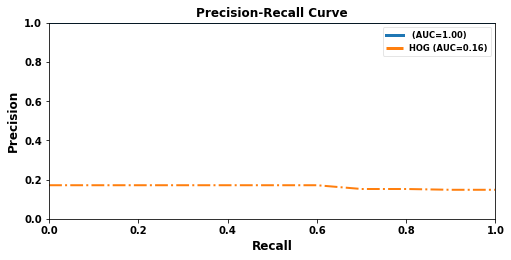

In [25]:
modelpath = PATH
#datapath = 'D:\\workspace\\data\\dataset\\06\\test'
#datapath = 'D:\\workspace\\data\\spring_summer'
datapath = 'D:\\workspace\\proj7643\\CampusLoopDataset'
plot(model,datapath)

In [33]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
device  = torch.device("cuda:0")
alexnet = models.alexnet(pretrained=True,progress=True).to(device)
#print(alexnet)
#print(alexnet.features[0].parameters())

In [36]:
#print(alexnet)
#alexnet = alexnet.to(device)
alexnet.features[0] = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=11,stride=4,padding=2)
alexnet.classifier[6] = nn.Linear(4096,3648)
lr = 1e-5
#optimizer = optim.Adam(alexnet.parameters(), lr=lr,weight_decay=0.995)

#in_layer_params = list(alexnet.features[0].parameters())
#out_layer1_params = list(alexnet.classifier[6].parameters())
#out_layer2_params = list(alexnet.classifier[4].parameters())
#out_layer3_params = list(alexnet.classifier[1].parameters())
#print(alexnet.features[0])
#base_params = filter(lambda p: id(p) not in in_layer_params+out_layer1_params+out_layer2_params+out_layer3_params,alexnet.parameters())
#base_params2 = list(map(id, alexnet.avgpool[0].parameters()))
#base_params3 = filter(lambda p: id(p) not in out_layer1_params+out_layer2_params+out_layer3_params,alexnet.classifier.parameters())

#for i in optimizer.param_groups:
#    print(i)
#    for k,v in i.items():
#        print(k)
#print(in_layer_params,out_layer1_params,out_layer2_params,out_layer3_params)
#print(base_params2)
optimizer = optim.Adam([{'params': alexnet.features[0].parameters()},
                        {'params': alexnet.classifier[6].parameters(),'lr': lr*1e5},
                        {'params': alexnet.classifier[4].parameters(),'lr': lr*1e5},
                        {'params': alexnet.classifier[1].parameters(),'lr': lr*1e5}],
                       lr=lr,weight_decay=0.995)
alexnet.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [30]:
PATH = 'model\\alexnet.pth'
#model.load_state_dict(torch.load(PATH))
#criterion = nn.MSELoss(reduction = 'sum')
criterion = nn.L1Loss(reduction = 'sum')

total_number = 10765 #output of writeDatabase
batch_size = 512
imgPath = 'D:\\workspace\\proj7643\\train\\train_data\\imgs'
despPath = 'D:\\workspace\\proj7643\\train\\train_data\\descriptors'
trainingset = TrainingSet(imgPath,despPath,total_number)
trainloader = DataLoader(trainingset,batch_size,shuffle=True)
max_epochs = 2000
iters = math.ceil(total_number/batch_size)
for epoch in range(max_epochs):
    avgloss = 0.0 # This loss is the average loss of an epoch
    t0 = time.time()
    for i,data in enumerate(trainloader):
        imgs,desps = data

        imgs,desps = imgs.to(device=device,dtype=torch.float), desps.to(device=device,dtype=torch.float)
        optimizer.zero_grad()
        outputs = alexnet(imgs)
        loss = criterion(outputs,desps)
        loss.backward()
        optimizer.step()
        avgloss += loss.item()
        if i%iters==iters-1:#According to the size of the dataset and batchsize
            print('[Epoch %d] loss: %.3f time used: %.3f' %
                      (epoch + 1, avgloss / 70,time.time()-t0))
            avgloss = 0.0
    if epoch%20 == 19:
        torch.save(alexnet.state_dict(), PATH)
        print('checkpoint saved')

[Epoch 1] loss: 23356083561852.438 time used: 3.282
[Epoch 2] loss: 438276501264.000 time used: 3.185
[Epoch 3] loss: 9604394555.359 time used: 2.969
[Epoch 4] loss: 20848319799.579 time used: 2.973
[Epoch 5] loss: 21058995825.491 time used: 2.973
[Epoch 6] loss: 29452492646.327 time used: 2.973
[Epoch 7] loss: 5936562010.072 time used: 2.974
[Epoch 8] loss: 32063780.135 time used: 2.996
[Epoch 9] loss: 27773446.849 time used: 2.980
[Epoch 10] loss: 7573531.016 time used: 3.033
[Epoch 11] loss: 47136344.485 time used: 2.999
[Epoch 12] loss: 2202352197.197 time used: 2.988
[Epoch 13] loss: 8064915.068 time used: 3.008
[Epoch 14] loss: 17665503.254 time used: 2.981
[Epoch 15] loss: 81592445.341 time used: 3.006
[Epoch 16] loss: 65902.953 time used: 2.987
[Epoch 17] loss: 64899.518 time used: 3.012
[Epoch 18] loss: 63109.374 time used: 3.194
[Epoch 19] loss: 62826.158 time used: 3.108
[Epoch 20] loss: 63179.412 time used: 3.067
checkpoint saved
[Epoch 21] loss: 62449.825 time used: 3.122


KeyboardInterrupt: 

memory path:  D:\workspace\proj7643\CampusLoopDataset\memory
live path:  D:\workspace\proj7643\CampusLoopDataset\live
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image001.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image002.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image003.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image004.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image005.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image006.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image007.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image008.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image009.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image010.jpg  to database
lo

[[0.7658615]]
[[0.764876]]
[[0.825986]]
[[0.81217295]]
[[0.8086739]]
[[0.8400196]]
[[0.8215388]]
[[0.82689136]]
[[0.82289267]]
[[0.7852199]]
[[0.7462629]]
[[0.785489]]
[[0.79075015]]
[[0.8098709]]
[[0.77157867]]
[[0.77503145]]
[[0.8083731]]
[[0.8062731]]
[[0.7833917]]
[[0.7999441]]
[[0.68928254]]
[[0.792008]]
[[0.80240273]]
[[0.7627408]]
[[0.709522]]
[[0.82393265]]
[[0.78200483]]
[[0.8252302]]
[[0.6920946]]
[[0.80734754]]
[[0.80456364]]
[[0.81948173]]
[[0.8019817]]
[[0.81383383]]
[[0.82372355]]
[[0.75849766]]
[[0.80686814]]
[[0.7036402]]
[[0.80692667]]
[[0.8126509]]
[[0.82744765]]
[[0.80435]]
[[0.8175222]]
[[0.84486264]]
[[0.8100773]]
[[0.72754055]]
[[0.752662]]
[[0.7610359]]
[[0.8012833]]
[[0.7892545]]
[[0.8255404]]
[[0.83373904]]
[[0.8328686]]
[[0.7630172]]
[[0.8428292]]
[[0.76974237]]
[[0.7863997]]
[[0.8050233]]
[[0.8303087]]
[[0.8386668]]
0.040915727615356445
Proposed match calc: 002 ,  011 , score =  [[0.8596905]] , Correct = [0]
Proposed match HOG: 002 ,  061 , score =  0.9990511

[[0.7527019]]
[[0.7893504]]
[[0.8247011]]
[[0.7926965]]
[[0.8199997]]
[[0.82763475]]
[[0.8416056]]
[[0.8374102]]
[[0.82393503]]
[[0.8423121]]
[[0.8204647]]
[[0.8151059]]
[[0.830387]]
[[0.80038124]]
[[0.7645906]]
[[0.7398007]]
[[0.79964536]]
[[0.7730161]]
[[0.8218093]]
[[0.8146323]]
[[0.794502]]
[[0.8112974]]
[[0.8496351]]
[[0.81298524]]
[[0.79530996]]
[[0.83351624]]
[[0.74748915]]
[[0.80032647]]
[[0.83612007]]
[[0.8347999]]
[[0.8034621]]
[[0.8175726]]
[[0.8359197]]
[[0.8375268]]
[[0.79432523]]
[[0.7959718]]
[[0.84480774]]
[[0.7860619]]
[[0.8179339]]
[[0.80844045]]
[[0.8419527]]
[[0.752754]]
[[0.82387936]]
[[0.81524116]]
[[0.66926384]]
[[0.7688416]]
[[0.75535256]]
[[0.8167069]]
[[0.71162295]]
[[0.7992072]]
[[0.7799666]]
[[0.7965739]]
[[0.7294974]]
[[0.8365523]]
[[0.8201849]]
[[0.8161302]]
[[0.8159877]]
[[0.80664015]]
[[0.8267516]]
[[0.69898444]]
[[0.82175344]]
[[0.72041607]]
[[0.8142447]]
[[0.8057022]]
[[0.82621396]]
[[0.805088]]
[[0.84780526]]
[[0.8317285]]
[[0.7871614]]
[[0.7712287]]


Proposed match HOG: 015 ,  061 , score =  0.9973829 , Correct = 0


[[0.8039311]]
[[0.7821802]]
[[0.8069738]]
[[0.85280895]]
[[0.8151634]]
[[0.79808235]]
[[0.80917823]]
[[0.82884276]]
[[0.8161104]]
[[0.79724675]]
[[0.78238225]]
[[0.81216264]]
[[0.8179566]]
[[0.7788265]]
[[0.8187149]]
[[0.8487973]]
[[0.78023314]]
[[0.7739336]]
[[0.7845528]]
[[0.78932977]]
[[0.7799953]]
[[0.8107842]]
[[0.8472051]]
[[0.8339082]]
[[0.81316704]]
[[0.80108017]]
[[0.7934525]]
[[0.8007469]]
[[0.8634505]]
[[0.77719665]]
[[0.77395296]]
[[0.7740375]]
[[0.7949873]]
[[0.799912]]
[[0.8363392]]
[[0.82770896]]
[[0.77332866]]
[[0.8295845]]
[[0.82621825]]
[[0.81111586]]
[[0.82604617]]
[[0.8285736]]
[[0.78675616]]
[[0.84446806]]
[[0.78879833]]
[[0.8050484]]
[[0.8029972]]
[[0.801511]]
[[0.8237425]]
[[0.82926]]
[[0.803769]]
[[0.80740976]]
[[0.833866]]
[[0.7823803]]
[[0.8353679]]
[[0.8404442]]
[[0.8235642]]
[[0.77541196]]
[[0.8119916]]
[[0.835966]]
[[0.73576427]]
[[0.77325296]]
[[0.7925536]]
[[0.8549776]]
[[0.76918507]]
[[0

[[0.8743349]]
[[0.86483]]
[[0.87679553]]
[[0.8751936]]
[[0.8459604]]
[[0.7929052]]
[[0.7851687]]
[[0.7954428]]
[[0.8712527]]
[[0.83993447]]
[[0.8657098]]
[[0.8628261]]
[[0.87535954]]
[[0.83264273]]
[[0.8506239]]
[[0.84399307]]
[[0.8567641]]
[[0.8255167]]
[[0.85113674]]
[[0.85668194]]
0.04088997840881348
Proposed match calc: 022 ,  021 , score =  [[0.89391404]] , Correct = [1]
Proposed match HOG: 022 ,  014 , score =  0.9887713 , Correct = 0


[[0.81804013]]
[[0.83272594]]
[[0.84115696]]
[[0.85360646]]
[[0.8514461]]
[[0.8178619]]
[[0.8689842]]
[[0.84947264]]
[[0.84266436]]
[[0.8630601]]
[[0.85187864]]
[[0.82929647]]
[[0.830088]]
[[0.85264015]]
[[0.80351794]]
[[0.80286676]]
[[0.8102262]]
[[0.8419726]]
[[0.86540484]]
[[0.84481215]]
[[0.8634765]]
[[0.85791874]]
[[0.8492714]]
[[0.8353577]]
[[0.86336476]]
[[0.8533928]]
[[0.8655164]]
[[0.8644644]]
[[0.85871184]]
[[0.8408783]]
[[0.8019855]]
[[0.8121393]]
[[0.83911353]]
[[0.8445119]]
[[0.84072685]]
[[0.83733493]]
[[0.8723104]]
[[0.82373255]]
[[

[[0.810491]]
[[0.8517026]]
[[0.82837427]]
[[0.8388662]]
[[0.83936334]]
[[0.83950865]]
[[0.83890486]]
[[0.8516041]]
[[0.8445587]]
[[0.8257443]]
[[0.81438565]]
[[0.82178956]]
[[0.85473216]]
[[0.8204267]]
[[0.80868113]]
[[0.8567785]]
[[0.83567286]]
[[0.78801364]]
[[0.84632957]]
[[0.872524]]
[[0.75335217]]
[[0.82384443]]
[[0.827717]]
[[0.8618456]]
[[0.7964787]]
[[0.81980854]]
[[0.8339058]]
[[0.80204844]]
[[0.8164122]]
[[0.8085525]]
[[0.85580117]]
[[0.8223611]]
[[0.84475553]]
[[0.81486785]]
[[0.80167115]]
[[0.7559545]]
[[0.8296486]]
[[0.7765607]]
[[0.8065038]]
[[0.82464015]]
[[0.8588526]]
[[0.84014636]]
[[0.8568765]]
[[0.81530523]]
[[0.7907596]]
[[0.8419461]]
[[0.79641956]]
[[0.77743727]]
[[0.8091117]]
[[0.81388915]]
[[0.82150185]]
[[0.82545567]]
[[0.8132893]]
[[0.8132005]]
[[0.7648051]]
[[0.801986]]
[[0.8163515]]
[[0.8148354]]
[[0.82324266]]
[[0.7808273]]
0.04285788536071777
Proposed match calc: 029 ,  060 , score =  [[0.872524]] , Correct = [0]
Proposed match HOG: 029 ,  061 , score =  0.

[[0.7972181]]
[[0.84036237]]
[[0.80718595]]
[[0.81360936]]
[[0.8092931]]
[[0.74721366]]
[[0.8155746]]
[[0.7610549]]
[[0.74999785]]
[[0.8223357]]
[[0.74866354]]
[[0.7831229]]
[[0.76439345]]
[[0.7858106]]
[[0.78100324]]
[[0.75784934]]
[[0.7814367]]
[[0.8100033]]
[[0.8283475]]
[[0.78511417]]
[[0.7676964]]
[[0.7815452]]
[[0.80911267]]
[[0.7725561]]
[[0.759915]]
[[0.768065]]
[[0.7774843]]
[[0.78931904]]
[[0.77606076]]
[[0.79261416]]
[[0.8221786]]
[[0.8540728]]
[[0.8014052]]
[[0.8042466]]
[[0.8014938]]
[[0.78719866]]
[[0.80716497]]
[[0.81234026]]
[[0.7828141]]
[[0.8417848]]
[[0.8565519]]
[[0.7936717]]
[[0.8656572]]
[[0.82607377]]
[[0.77118194]]
[[0.80345166]]
[[0.83435583]]
[[0.82173324]]
[[0.84880674]]
[[0.7957461]]
[[0.75553346]]
[[0.7744148]]
[[0.7612215]]
[[0.8089333]]
[[0.77881277]]
[[0.7881816]]
[[0.8193277]]
[[0.8044582]]
[[0.76465434]]
[[0.7819452]]
[[0.7747469]]
[[0.8102986]]
[[0.8021366]]
[[0.7520821]]
[[0.7766105]]
[[0.8195449]]
[[0.79769135]]
[[0.77215713]]
[[0.73151255]]
[[0.768

[[0.8011433]]
[[0.79625165]]
[[0.7244193]]
[[0.80910563]]
[[0.7241808]]
[[0.83583516]]
[[0.8262869]]
[[0.8516254]]
[[0.8475468]]
[[0.87251675]]
[[0.82038283]]
[[0.8275908]]
[[0.7508547]]
[[0.80210906]]
[[0.77542746]]
[[0.8058502]]
[[0.81547856]]
[[0.8346214]]
[[0.8517744]]
[[0.8077369]]
[[0.75262725]]
[[0.81393945]]
[[0.7934046]]
[[0.8014647]]
[[0.8052636]]
[[0.8166618]]
[[0.8112304]]
0.042884111404418945
Proposed match calc: 042 ,  083 , score =  [[0.87251675]] , Correct = [0]
Proposed match HOG: 042 ,  061 , score =  0.9988007 , Correct = 0


[[0.83760095]]
[[0.81141174]]
[[0.800881]]
[[0.8138371]]
[[0.83026016]]
[[0.77148354]]
[[0.8422778]]
[[0.8090158]]
[[0.77182174]]
[[0.8332165]]
[[0.79200387]]
[[0.80845]]
[[0.8458415]]
[[0.7945365]]
[[0.76030326]]
[[0.78428507]]
[[0.81437755]]
[[0.7946663]]
[[0.81291527]]
[[0.7846961]]
[[0.79228806]]
[[0.79168916]]
[[0.8086407]]
[[0.78835076]]
[[0.8077085]]
[[0.76711476]]
[[0.80142426]]
[[0.81422496]]
[[0.79772425]]
[[0.7831278]]
[[0.8068472]]
[

[[0.8260332]]
[[0.8275399]]
[[0.84819955]]
[[0.8540454]]
[[0.84314483]]
[[0.8465237]]
[[0.8397007]]
[[0.8421357]]
[[0.7685684]]
[[0.7964597]]
[[0.8186207]]
[[0.8233072]]
[[0.8426852]]
[[0.801899]]
[[0.8244169]]
[[0.79047287]]
[[0.84833974]]
[[0.8620462]]
[[0.70167905]]
[[0.85331476]]
[[0.8255962]]
[[0.79254997]]
[[0.7283911]]
[[0.78572077]]
[[0.8194878]]
[[0.7928984]]
[[0.74094653]]
[[0.83990324]]
[[0.82019323]]
[[0.83335793]]
[[0.8068251]]
[[0.8289419]]
[[0.8257654]]
[[0.71290797]]
[[0.83061886]]
[[0.7478558]]
[[0.8341981]]
[[0.8366195]]
[[0.848495]]
[[0.85237044]]
[[0.841679]]
[[0.8474234]]
[[0.83498716]]
[[0.73612976]]
[[0.84275657]]
[[0.7679244]]
[[0.83677953]]
[[0.8241408]]
[[0.8427745]]
[[0.85570157]]
[[0.8320612]]
[[0.7659846]]
[[0.81764567]]
[[0.81545925]]
[[0.79594445]]
[[0.79585445]]
[[0.8077041]]
[[0.8388921]]
0.041880130767822266
Proposed match calc: 049 ,  060 , score =  [[0.8620462]] , Correct = [0]
Proposed match HOG: 049 ,  061 , score =  0.99825144 , Correct = 0


[[0.

[[0.82320595]]
[[0.8041471]]
[[0.8471754]]
[[0.856455]]
[[0.8648749]]
[[0.82402766]]
[[0.8488191]]
[[0.8204523]]
[[0.8596082]]
[[0.83593774]]
[[0.84204257]]
[[0.815919]]
[[0.8278078]]
[[0.83751416]]
[[0.79005015]]
[[0.7790325]]
[[0.81627345]]
[[0.81641847]]
[[0.8433329]]
[[0.8265412]]
[[0.8623402]]
[[0.8461404]]
[[0.83874583]]
[[0.87480783]]
[[0.8841819]]
[[0.8462001]]
[[0.8354666]]
[[0.8472042]]
[[0.8362415]]
[[0.84268504]]
[[0.81087947]]
[[0.8025993]]
[[0.85658693]]
[[0.8011643]]
[[0.8118893]]
[[0.852741]]
[[0.8394365]]
[[0.8345374]]
[[0.8456528]]
[[0.8413639]]
[[0.8058224]]
[[0.8278252]]
[[0.81359327]]
[[0.8252444]]
[[0.8550843]]
[[0.8652586]]
[[0.84738135]]
[[0.8278588]]
[[0.85435754]]
[[0.82791805]]
[[0.7726859]]
[[0.81999147]]
[[0.8336961]]
[[0.8456861]]
[[0.84715337]]
[[0.82362]]
[[0.84668]]
[[0.80043757]]
[[0.83405477]]
[[0.8390785]]
[[0.7011699]]
[[0.7875856]]
[[0.82331836]]
[[0.7941866]]
[[0.74857223]]
[[0.8038585]]
[[0.82687545]]
[[0.80851465]]
[[0.7365885]]
[[0.85210395]]
[

[[0.8081955]]
0.03989887237548828
Proposed match calc: 062 ,  089 , score =  [[0.87205833]] , Correct = [0]
Proposed match HOG: 062 ,  061 , score =  0.99592876 , Correct = 1


[[0.81217384]]
[[0.820452]]
[[0.81866664]]
[[0.8283451]]
[[0.83246994]]
[[0.7499027]]
[[0.8486737]]
[[0.81013066]]
[[0.8026314]]
[[0.83266735]]
[[0.7829269]]
[[0.8111968]]
[[0.8236296]]
[[0.78050673]]
[[0.8367498]]
[[0.8228358]]
[[0.8365878]]
[[0.75732106]]
[[0.8111099]]
[[0.79594624]]
[[0.7729957]]
[[0.769444]]
[[0.84066266]]
[[0.82946366]]
[[0.80177546]]
[[0.7908155]]
[[0.75922304]]
[[0.76569045]]
[[0.7884075]]
[[0.777063]]
[[0.81221116]]
[[0.7992891]]
[[0.8250334]]
[[0.8098103]]
[[0.81305224]]
[[0.8244333]]
[[0.8150309]]
[[0.79480684]]
[[0.82278484]]
[[0.8529991]]
[[0.8247147]]
[[0.8264015]]
[[0.81770027]]
[[0.8008394]]
[[0.7984009]]
[[0.83406764]]
[[0.8513036]]
[[0.8304901]]
[[0.83425635]]
[[0.802991]]
[[0.76576173]]
[[0.8107122]]
[[0.78983444]]
[[0.80572927]]
[[0.8097236]]
[[0.8031495]]
[[0.81919193]]
[[0.7

[[0.6489264]]
[[0.71685106]]
[[0.74542236]]
[[0.69672865]]
[[0.74546325]]
[[0.78689015]]
[[0.7692545]]
[[0.72191674]]
[[0.76937985]]
[[0.77186495]]
[[0.7568753]]
[[0.7558596]]
[[0.75309896]]
[[0.7725898]]
[[0.7714198]]
[[0.8036172]]
[[0.7609609]]
[[0.72520876]]
[[0.7428535]]
[[0.7700317]]
[[0.75935465]]
[[0.7691765]]
[[0.77963793]]
[[0.7294749]]
[[0.74282146]]
[[0.7324939]]
[[0.75631183]]
[[0.72931623]]
[[0.7501184]]
[[0.7460059]]
[[0.7768979]]
[[0.69863844]]
[[0.745767]]
[[0.7738513]]
[[0.7405103]]
[[0.7322034]]
[[0.7255221]]
[[0.751655]]
[[0.73948044]]
[[0.7024116]]
[[0.76880544]]
[[0.74561656]]
[[0.7688334]]
[[0.7068044]]
[[0.7674963]]
[[0.73849916]]
[[0.7810687]]
[[0.7591026]]
[[0.7706157]]
[[0.7064017]]
[[0.7908385]]
[[0.7973341]]
[[0.7161804]]
[[0.7807187]]
[[0.7108411]]
[[0.7685144]]
[[0.75410604]]
[[0.71086454]]
[[0.68406034]]
[[0.78049433]]
[[0.75176996]]
[[0.7309317]]
[[0.75945276]]
[[0.74538517]]
[[0.7415979]]
[[0.76433086]]
[[0.727288]]
[[0.75627315]]
[[0.6516416]]
[[0.7635

[[0.8401116]]
[[0.8181559]]
[[0.8581198]]
[[0.8054553]]
0.040840864181518555
Proposed match calc: 075 ,  099 , score =  [[0.8581198]] , Correct = [0]
Proposed match HOG: 075 ,  073 , score =  0.9984018 , Correct = 1


[[0.82416856]]
[[0.7954811]]
[[0.8095646]]
[[0.8458152]]
[[0.83917916]]
[[0.781509]]
[[0.826336]]
[[0.8260745]]
[[0.87085605]]
[[0.8409972]]
[[0.85357755]]
[[0.8516698]]
[[0.81190836]]
[[0.8514661]]
[[0.807209]]
[[0.8085239]]
[[0.82689726]]
[[0.8261596]]
[[0.8462708]]
[[0.8585277]]
[[0.8550943]]
[[0.8667089]]
[[0.84899557]]
[[0.8591344]]
[[0.86869955]]
[[0.84851897]]
[[0.81668735]]
[[0.84765923]]
[[0.8831736]]
[[0.8384948]]
[[0.7989364]]
[[0.79221416]]
[[0.8418426]]
[[0.78870726]]
[[0.8177898]]
[[0.80889696]]
[[0.83993465]]
[[0.8104576]]
[[0.8449727]]
[[0.8643773]]
[[0.7968544]]
[[0.8351352]]
[[0.8330485]]
[[0.8329613]]
[[0.8445926]]
[[0.8537955]]
[[0.8473891]]
[[0.8539672]]
[[0.83752394]]
[[0.82937956]]
[[0.8054918]]
[[0.8013295]]
[[0.87806916]]
[[0.81386024]]
[[0.819631

[[0.8118073]]
[[0.87427294]]
[[0.84648925]]
[[0.8375186]]
[[0.87755305]]
[[0.8730418]]
[[0.8700725]]
[[0.8649358]]
[[0.8124461]]
[[0.79084015]]
[[0.7990545]]
[[0.8414736]]
[[0.8153856]]
[[0.82159424]]
[[0.81419706]]
[[0.8613244]]
[[0.8568338]]
[[0.8251124]]
[[0.8379533]]
[[0.74247485]]
[[0.7947756]]
[[0.80126274]]
[[0.80049264]]
[[0.8016196]]
[[0.87263936]]
[[0.8154246]]
[[0.8566334]]
[[0.7535308]]
[[0.85895056]]
[[0.8152323]]
[[0.86264896]]
[[0.81226194]]
[[0.8350657]]
[[0.8594874]]
[[0.77780545]]
[[0.8354353]]
[[0.7526301]]
[[0.8329898]]
[[0.825973]]
[[0.8421036]]
[[0.8511286]]
[[0.8342838]]
[[0.88425195]]
[[0.8298247]]
[[0.80380636]]
[[0.7714599]]
[[0.7690865]]
[[0.8278896]]
[[0.7774865]]
[[0.8322505]]
[[0.844076]]
[[0.863302]]
[[0.79634]]
[[0.82000595]]
[[0.82216865]]
[[0.8747874]]
[[0.84330225]]
[[0.84313285]]
[[0.83347785]]
0.04288458824157715
Proposed match calc: 082 ,  019 , score =  [[0.89971364]] , Correct = [0]
Proposed match HOG: 082 ,  061 , score =  0.9951787 , Correct = 

[[0.824347]]
[[0.81112194]]
[[0.8145113]]
[[0.8222459]]
[[0.8141465]]
[[0.7579507]]
[[0.83007705]]
[[0.7639246]]
[[0.7845353]]
[[0.82015055]]
[[0.7736269]]
[[0.80794203]]
[[0.8036754]]
[[0.8085691]]
[[0.75289166]]
[[0.78988874]]
[[0.82918954]]
[[0.81234473]]
[[0.81028324]]
[[0.84399724]]
[[0.80161047]]
[[0.7999091]]
[[0.83913445]]
[[0.81805086]]
[[0.81294405]]
[[0.80160356]]
[[0.79189706]]
[[0.7970595]]
[[0.80667424]]
[[0.8141784]]
[[0.85244286]]
[[0.82027006]]
[[0.8303306]]
[[0.76763695]]
[[0.7984151]]
[[0.80098796]]
[[0.8209003]]
[[0.8193338]]
[[0.8073817]]
[[0.846359]]
[[0.83529013]]
[[0.8034235]]
[[0.83903164]]
[[0.8561574]]
[[0.7812358]]
[[0.82729626]]
[[0.81623065]]
[[0.8064801]]
[[0.8242117]]
[[0.8098578]]
[[0.7479037]]
[[0.81785357]]
[[0.8092634]]
[[0.79332745]]
[[0.81444937]]
[[0.8349928]]
[[0.8442671]]
[[0.77525955]]
[[0.77717054]]
[[0.8384355]]
[[0.7911277]]
[[0.8201617]]
[[0.8059286]]
[[0.80868095]]
[[0.79728925]]
[[0.8019023]]
[[0.859676]]
[[0.79843897]]
[[0.788282]]
[[0.8

[[0.76168895]]
[[0.80380255]]
[[0.79754746]]
[[0.82873416]]
[[0.84030545]]
[[0.82809204]]
[[0.7983514]]
[[0.7821566]]
[[0.8159164]]
[[0.83097386]]
[[0.7682659]]
[[0.7917739]]
[[0.8251603]]
[[0.8098501]]
0.03983473777770996
Proposed match calc: 095 ,  043 , score =  [[0.8618446]] , Correct = [0]
Proposed match HOG: 095 ,  074 , score =  0.9973029 , Correct = 0


[[0.81976354]]
[[0.82008564]]
[[0.7784238]]
[[0.7997097]]
[[0.8140755]]
[[0.6972496]]
[[0.8277617]]
[[0.7319673]]
[[0.7725818]]
[[0.80778277]]
[[0.7131561]]
[[0.771092]]
[[0.7724819]]
[[0.7461412]]
[[0.76022446]]
[[0.7670903]]
[[0.81435513]]
[[0.7525977]]
[[0.7636452]]
[[0.7936107]]
[[0.75900066]]
[[0.76981723]]
[[0.8181266]]
[[0.8004095]]
[[0.7735729]]
[[0.75755477]]
[[0.7412902]]
[[0.7749771]]
[[0.78566587]]
[[0.7506572]]
[[0.78783387]]
[[0.81144786]]
[[0.8476505]]
[[0.77354777]]
[[0.80188394]]
[[0.80589265]]
[[0.7695118]]
[[0.82496935]]
[[0.7405647]]
[[0.80837977]]
[[0.80576116]]
[[0.77855206]]
[[0.816366]]
[[0.7925467]]
[[0.

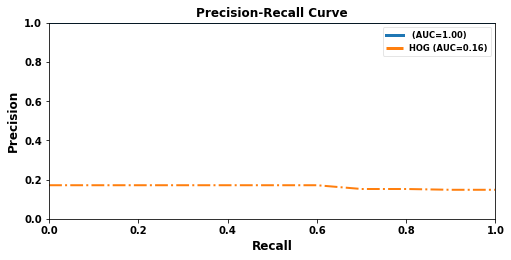

In [37]:
#datapath = 'D:\\workspace\\data\\dataset\\06\\test'
#datapath = 'D:\\workspace\\data\\spring_summer'
datapath = 'D:\workspace\proj7643\CampusLoopDataset'
plot(alexnet,datapath)

# Dataset

# Other model
##### pretrained ones

# Other methods (other than 'projective tranformation + HOG'?)